## uplift modeling
- 以下是分類範例

In [1]:
!pip install scikit-uplift

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 42 kB 715 kB/s 


In [60]:
from sklearn.model_selection import train_test_split
from sklift.datasets import fetch_x5
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)
%matplotlib inline

In [3]:
dataset = fetch_x5()
dataset.keys()

Part 1: X5 train:   0%|          | 0.00/1.18M [00:00<?, ?iB/s]

Part 2: X5 clients:   0%|          | 0.00/7.64M [00:00<?, ?iB/s]

Part 3: X5 purchases:   0%|          | 0.00/670M [00:00<?, ?iB/s]

dict_keys(['data', 'target', 'treatment', 'DESCR', 'feature_names', 'target_name', 'treatment_name'])

In [4]:
dataset.treatment

0         0
1         1
2         1
3         1
4         1
         ..
200034    0
200035    0
200036    0
200037    1
200038    0
Name: treatment_flg, Length: 200039, dtype: int64

In [5]:
print(f"Dataset type: {type(dataset)}\n")
print(f"Dataset features shape: {dataset.data['clients'].shape}")  # 用戶資料
print(f"Dataset features shape: {dataset.data['train'].shape}")   # 訓練資料(但為什麼只有一個feature?) -> 只是client_id
print(f"Dataset target shape: {dataset.target.shape}")        # 目標資料
print(f"Dataset treatment shape: {dataset.treatment.shape}")

Dataset type: <class 'sklearn.utils.Bunch'>

Dataset features shape: (400162, 5)
Dataset features shape: (200039, 1)
Dataset target shape: (200039,)
Dataset treatment shape: (200039,)


In [6]:
# extract data
df_clients = dataset.data['clients'].set_index("client_id")   # 取得用戶的資料，並將其index設定
df_train = pd.concat([dataset.data['train'], dataset.treatment , dataset.target], axis=1).set_index("client_id")
indices_test = pd.Index(set(df_clients.index) - set(df_train.index))

# extracting features
df_features = df_clients.copy()
df_features['first_issue_time'] = \
    (pd.to_datetime(df_features['first_issue_date'])
     - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')
df_features['first_redeem_time'] = \
    (pd.to_datetime(df_features['first_redeem_date'])
     - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')
df_features['issue_redeem_delay'] = df_features['first_redeem_time'] \
    - df_features['first_issue_time']
df_features = df_features.drop(['first_issue_date', 'first_redeem_date'], axis=1)

# 因為nan模型會出錯，這邊很粗糙的先解決
df_features.fillna(method='backfill', inplace=True)

indices_learn, indices_valid = train_test_split(df_train.index, test_size=0.3, random_state=123)

In [7]:
# 將資料轉換好，得到一些特徵用於訓練

df_features

,age,gender,first_issue_time,first_redeem_time,issue_redeem_delay
client_id,,,,,
000012768d,45,U,1501947648,1.515094e+09,13146559.0
000036f903,72,F,1491832463,1.492951e+09,1118613.0
000048b7a6,68,F,1544880791,1.511522e+09,15978107.0
000073194a,60,F,1495544174,1.511522e+09,15978107.0
00007c7133,67,U,1495469828,1.546277e+09,50806825.0
...,...,...,...,...,...
fffece623e,67,U,1526224170,1.545938e+09,19713429.0
ffff3dfff8,56,F,1541088412,1.544204e+09,3115615.0
ffffaab9da,23,F,1503686604,1.512756e+09,9068995.0


In [8]:
df_train

,treatment_flg,target
client_id,,
000012768d,0,1
000036f903,1,1
00010925a5,1,1
0001f552b0,1,1
00020e7b18,1,1
...,...,...
fffe0abb97,0,0
fffe0ed719,0,1
fffea1204c,0,1


In [9]:
X_train = df_features.loc[indices_learn, :]          # 訓練特徵
y_train = df_train.loc[indices_learn, 'target']        # 只取target的維度
treat_train = df_train.loc[indices_learn, 'treatment_flg']  # 只取treatment的維度

X_val = df_features.loc[indices_valid, :]
y_val = df_train.loc[indices_valid, 'target']
treat_val =  df_train.loc[indices_valid, 'treatment_flg']

X_train_full = df_features.loc[df_train.index, :]
y_train_full = df_train.loc[:, 'target']
treat_train_full = df_train.loc[:, 'treatment_flg']

X_test = df_features.loc[indices_test, :]

# cat_features = ['gender']

models_results = {
    'approach': [],
    'uplift@30%': []
}

In [71]:
models_results = {
    'approach': [],
    'uplift@30%': []
}

看一下我們總共需要什麼資料！

In [10]:
X_train

,age,gender,first_issue_time,first_redeem_time,issue_redeem_delay
client_id,,,,,
ad6561e2d8,50,F,1512322431,1.527102e+09,14779510.0
7c1ccbf93f,24,F,1510331629,1.519326e+09,8994516.0
b58fadcab6,36,U,1509657465,1.537045e+09,27387871.0
e99e6fabb9,79,F,1526466080,1.527713e+09,1247284.0
27fb6f8520,34,F,1500320188,1.513332e+09,13012137.0
...,...,...,...,...,...
999d284453,72,U,1540991437,1.554559e+09,13567144.0
f634deea4e,35,U,1517752292,1.520877e+09,3124210.0
16cb4f99b0,50,F,1519380153,1.559324e+09,39944103.0


In [11]:
y_train

client_id
ad6561e2d8    1
7c1ccbf93f    1
b58fadcab6    1
e99e6fabb9    0
27fb6f8520    1
             ..
999d284453    1
f634deea4e    1
16cb4f99b0    1
23c2b72b2e    1
1430184499    1
Name: target, Length: 140027, dtype: int64

In [12]:
treat_train

client_id
ad6561e2d8    1
7c1ccbf93f    1
b58fadcab6    1
e99e6fabb9    0
27fb6f8520    1
             ..
999d284453    1
f634deea4e    0
16cb4f99b0    0
23c2b72b2e    1
1430184499    0
Name: treatment_flg, Length: 140027, dtype: int64

使用 TwoModels 去實現 uplift model

In [13]:
from sklift.models import TwoModels
from sklearn.ensemble import RandomForestClassifier
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds

In [14]:
X_train.columns

Index(['age', 'gender', 'first_issue_time', 'first_redeem_time',
       'issue_redeem_delay'],
      dtype='object')

In [15]:
tm = TwoModels(
    estimator_trmnt=RandomForestClassifier(random_state=222),
    estimator_ctrl=RandomForestClassifier(random_state=222),
    method='vanilla'
)

tm.fit(
    X_train[['age', 'first_issue_time', 'first_redeem_time',
       'issue_redeem_delay']], y_train, treat_train,
)

uplift_tm = tm.predict(X_val[['age', 'first_issue_time', 'first_redeem_time',
       'issue_redeem_delay']])
tm_score = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.3)

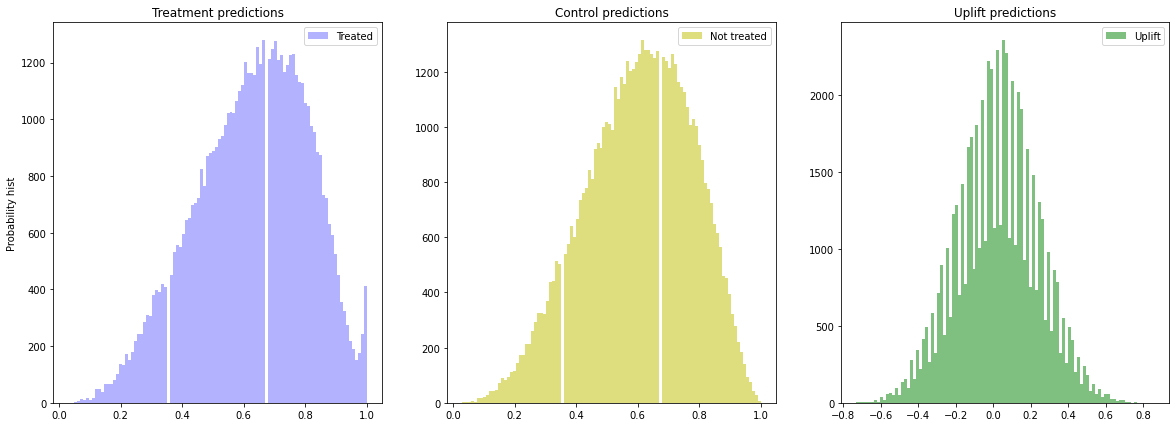

In [72]:
models_results['approach'].append('TwoModels')
models_results['uplift@30%'].append(tm_score)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

#### 使用 NN 類模型模擬 (Two Model的優勢，所有模型都可使用)


In [17]:
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler

In [18]:
X_train

,age,gender,first_issue_time,first_redeem_time,issue_redeem_delay
client_id,,,,,
ad6561e2d8,50,F,1512322431,1.527102e+09,14779510.0
7c1ccbf93f,24,F,1510331629,1.519326e+09,8994516.0
b58fadcab6,36,U,1509657465,1.537045e+09,27387871.0
e99e6fabb9,79,F,1526466080,1.527713e+09,1247284.0
27fb6f8520,34,F,1500320188,1.513332e+09,13012137.0
...,...,...,...,...,...
999d284453,72,U,1540991437,1.554559e+09,13567144.0
f634deea4e,35,U,1517752292,1.520877e+09,3124210.0
16cb4f99b0,50,F,1519380153,1.559324e+09,39944103.0


In [19]:
def get_nn_model():
    inputs = keras.Input(shape=(4,))
    x = layers.Dense(units=32, activation='relu')(inputs)
    x = layers.Dense(units=8, activation='relu')(x)
    outputs = layers.Dense(units=1, activation='sigmoid')(x)
    return keras.Model(inputs, outputs)

In [20]:
nn = get_nn_model()
nn.compile(optimizer=keras.optimizers.Adam(), loss=['binary_crossentropy'], metrics=['acc'])

## DNN
1. 分為 Treated and not treated data
2. 透過 分組去建立 treadted model and not treated model
3. 預測 new user's target value by above two models
4. 相減 取得 uplift
5. 取得 top-k uplift 做為策略投遞對象

In [54]:
# 1. 分為 Treated and not treated data

scaler = StandardScaler()
scaler.fit(X_train[['age', 'first_issue_time', 'first_redeem_time',
       'issue_redeem_delay']])
X_train_treat_scaled = scaler.transform(X_train[treat_train == 1][['age', 'first_issue_time', 'first_redeem_time',
       'issue_redeem_delay']])
X_val_treat_scaled = scaler.transform(X_val[treat_val == 1][['age', 'first_issue_time', 'first_redeem_time',
       'issue_redeem_delay']])

X_train_not_treat_scaled = scaler.transform(X_train[treat_train == 0][['age', 'first_issue_time', 'first_redeem_time',
       'issue_redeem_delay']])
X_val_not_treat_scaled = scaler.transform(X_val[treat_val == 0][['age', 'first_issue_time', 'first_redeem_time',
       'issue_redeem_delay']])

y_train_treat = y_train[treat_train == 1]
y_train_not_treat = y_train[treat_train == 0]
y_val_treat = y_val[treat_val == 1]
y_val_not_treat = y_val[treat_val == 0]

In [55]:
# 2. 透過 分組去建立 treadted model and not treated model

nn_treat = get_nn_model()
nn_treat.compile(optimizer=keras.optimizers.Adam(), loss=['binary_crossentropy'], metrics=['acc'])
nn.fit(X_train_treat_scaled, y_train_treat, batch_size=64, epochs=30, validation_data=(X_val_treat_scaled, y_val_treat))

Epoch 1/30
1095/1095 [==============================] - 3s 3ms/step - loss: 0.6328 - acc: 0.6592 - val_loss: 0.6341 - val_acc: 0.6586
Epoch 2/30
1095/1095 [==============================] - 3s 3ms/step - loss: 0.6327 - acc: 0.6592 - val_loss: 0.6339 - val_acc: 0.6592
Epoch 3/30
1095/1095 [==============================] - 4s 4ms/step - loss: 0.6327 - acc: 0.6588 - val_loss: 0.6343 - val_acc: 0.6587
Epoch 4/30
1095/1095 [==============================] - 5s 5ms/step - loss: 0.6326 - acc: 0.6594 - val_loss: 0.6341 - val_acc: 0.6586
Epoch 5/30
1095/1095 [==============================] - 3s 3ms/step - loss: 0.6326 - acc: 0.6597 - val_loss: 0.6338 - val_acc: 0.6583
Epoch 6/30
1095/1095 [==============================] - 4s 3ms/step - loss: 0.6323 - acc: 0.6597 - val_loss: 0.6334 - val_acc: 0.6590
Epoch 7/30
1095/1095 [==============================] - 6s 5ms/step - loss: 0.6323 - acc: 0.6597 - val_loss: 0.6344 - val_acc: 0.6588
Epoch 8/30
1095/1095 [==============================] - 3s 2ms

In [56]:
# 2. 透過 分組去建立 treadted model and not treated model

nn_not_treat = get_nn_model()
nn_not_treat.compile(optimizer=keras.optimizers.Adam(), loss=['binary_crossentropy'], metrics=['acc'])
nn_not_treat.fit(X_train_not_treat_scaled, y_train_not_treat, batch_size=64, epochs=30, validation_data=(X_val_not_treat_scaled, y_val_not_treat))

Epoch 1/30
1094/1094 [==============================] - 3s 3ms/step - loss: 0.6645 - acc: 0.6093 - val_loss: 0.6618 - val_acc: 0.6155
Epoch 2/30
1094/1094 [==============================] - 3s 2ms/step - loss: 0.6602 - acc: 0.6189 - val_loss: 0.6604 - val_acc: 0.6209
Epoch 3/30
1094/1094 [==============================] - 3s 2ms/step - loss: 0.6593 - acc: 0.6211 - val_loss: 0.6598 - val_acc: 0.6212
Epoch 4/30
1094/1094 [==============================] - 3s 2ms/step - loss: 0.6587 - acc: 0.6222 - val_loss: 0.6602 - val_acc: 0.6189
Epoch 5/30
1094/1094 [==============================] - 4s 4ms/step - loss: 0.6584 - acc: 0.6233 - val_loss: 0.6592 - val_acc: 0.6224
Epoch 6/30
1094/1094 [==============================] - 3s 3ms/step - loss: 0.6582 - acc: 0.6235 - val_loss: 0.6587 - val_acc: 0.6238
Epoch 7/30
1094/1094 [==============================] - 3s 3ms/step - loss: 0.6580 - acc: 0.6242 - val_loss: 0.6587 - val_acc: 0.6234
Epoch 8/30
1094/1094 [==============================] - 3s 3ms

In [57]:
X_val_scaled = scaler.transform(X_val[['age', 'first_issue_time', 'first_redeem_time',
       'issue_redeem_delay']])

In [62]:
# 3. 預測 new user's target value by above two models

nn_treat.predict(X_val_scaled)

1876/1876 [==============================] - 3s 1ms/step


array([[0.69149894],
       [0.60260034],
       [0.50538117],
       ...,
       [0.43748072],
       [0.40934512],
       [0.20482425]], dtype=float32)

In [63]:
# 3. 預測 new user's target value by above two models

nn_not_treat.predict(X_val_scaled)

1876/1876 [==============================] - 3s 1ms/step


array([[0.32999852],
       [0.7115843 ],
       [0.58162004],
       ...,
       [0.57523435],
       [0.6328938 ],
       [0.5787898 ]], dtype=float32)

In [58]:
uplift_tm_nn = nn_treat.predict(X_val_scaled) - nn_not_treat.predict(X_val_scaled)
uplift_tm_nn

1876/1876 [==============================] - 3s 1ms/step


array([[ 0.3615004 ],
       [-0.10898399],
       [-0.07623887],
       ...,
       [-0.13775364],
       [-0.22354868],
       [-0.3739655 ]], dtype=float32)

In [73]:
uplift_tm_nn.flatten()

array([ 0.3615004 , -0.10898399, -0.07623887, ..., -0.13775364,
       -0.22354868, -0.3739655 ], dtype=float32)

1876/1876 [==============================] - 3s 1ms/step


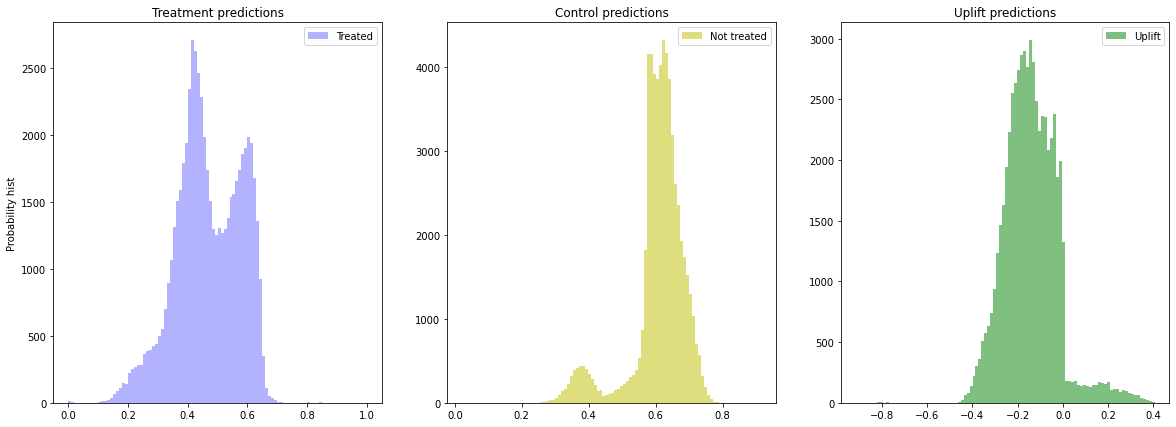

In [75]:
tm_nn_score = uplift_at_k(y_true=y_val, uplift=uplift_tm_nn.flatten(), treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('TwoModels_nn')
models_results['uplift@30%'].append(tm_nn_score)

plot_uplift_preds(trmnt_preds=nn_treat.predict(X_val_scaled).flatten(), ctrl_preds=nn_not_treat.predict(X_val_scaled).flatten());

In [76]:
models_results

{'approach': ['TwoModels', 'TwoModels_nn'],
 'uplift@30%': [0.042683187810306444, 0.030141897539704088]}

In [77]:
pd.DataFrame(data=models_results).sort_values('uplift@30%', ascending=False)

,approach,uplift@30%
0,TwoModels,0.042683
1,TwoModels_nn,0.030142
